In [ ]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

if os.path.basename(os.getcwd()) != 'DeepPurple':
    os.chdir('..')

from libs.pconv_model import PConvUnet

%load_ext autoreload
%autoreload 2
plt.ioff()

IMAGE_DIR='./data/images'
BATCH_SIZE = 4

**Creating data generator**

In [2]:
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            #Next image
            ori = next(generator)
            
            #64×64 centered Mask
            mask = mask = np.ones((256, 256, 3), np.uint8)
            cv2.rectangle(mask, (96, 96), (159, 159), (0, 0, 0), -1)
            
            mask = np.stack([mask for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

#Training images
train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(256, 256), 
    batch_size=BATCH_SIZE,
    classes=['train']
)

#Validation images
val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(256, 256), 
    batch_size=BATCH_SIZE,
    classes=['validation']
)

#Test images
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(256, 256), 
    batch_size=BATCH_SIZE,
    classes=['test']
)

**Load test images**

Found 1916 images belonging to 1 classes.


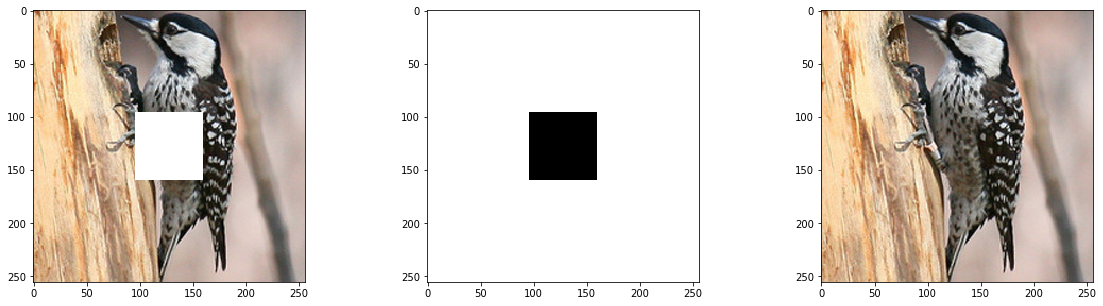

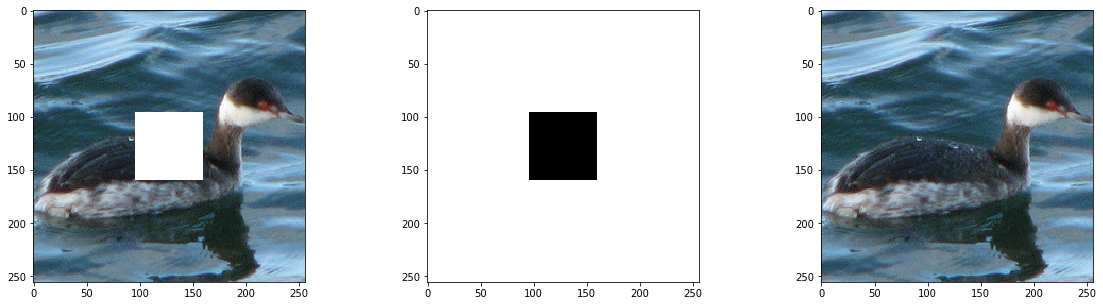

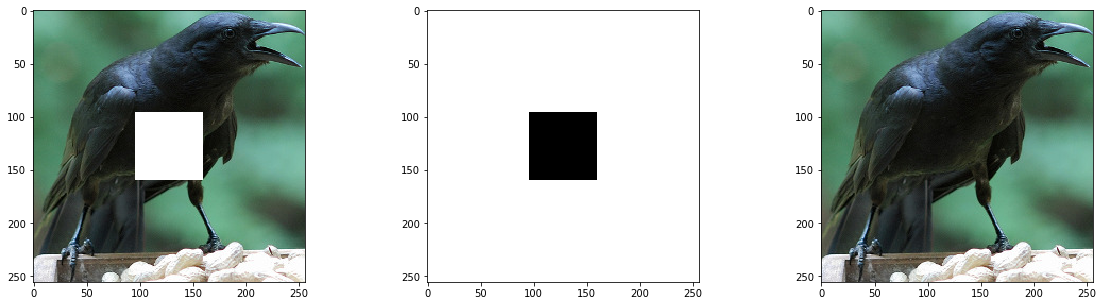

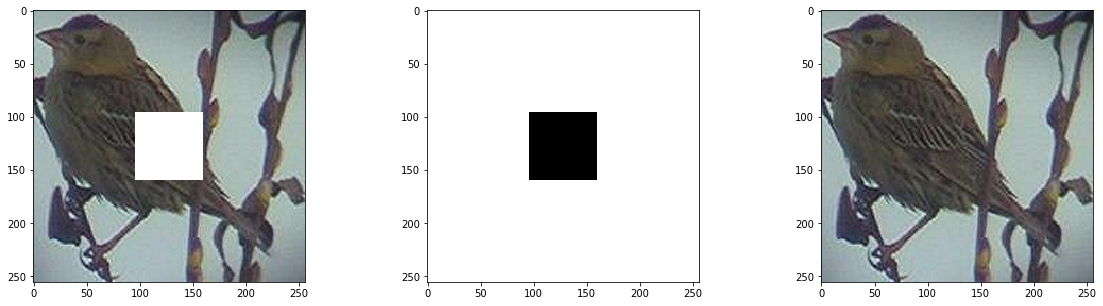

In [3]:
test_data = next(test_generator)
(masked, mask), ori = test_data

for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

**Define post-epoch callback**

In [ ]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    #Save test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig('./data/log/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

**Train model**

In [ ]:
#Initial weights set from vgg16 pretrained model
model = PConvUnet(img_rows=256, img_cols=256, vgg_weights='./data/pytorch_vgg16.h5')

In [ ]:
FOLDER = './data/log/weights'

model.fit_generator(
    train_generator, 
    steps_per_epoch=1000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,  
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

**Show predictions**

In [4]:
#Load trained model
model = PConvUnet(img_rows=256, img_cols=256)
model.load("./data/log/weights/weights.30-1.64.h5",train_bn=False,lr=0.00005)

In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig('./data/log/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break